In [1]:
import os
#os.chdir("../scripts/causal_transformer")
os.chdir("../../interpret_toy_lms/scripts/transformer")

In [2]:
import json, math, sys, random, re, pytz, argparse, warnings, matplotlib
from datetime import datetime
timezone = pytz.timezone('America/New_York') 
#sys.path.append("../../../interpret_toy_lms/scripts")
from model import Causal_Transformer, apply_rotary_pos_emb 
from config import *
from dataset import sequences_collator
from utils import get_acc, trim_task
import torch
import numpy as np
from tqdm import tqdm, trange
from functools import partial
from collections import defaultdict, Counter
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.decomposition import PCA
from einops import rearrange
torch.set_printoptions(precision=4, sci_mode=False)
np.set_printoptions(precision=4, suppress=True, threshold=np.inf)

/home/yingshac/workspace/llms_do_math/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
OUTPUT_DIR = "/home/yingshac/workspace/llms_do_math/scripts/causal_transformer/output_iclr/"
CKPT_DIR = "/data/yingshac/llms_do_math/scripts/causal_transformer/output_iclr/"
EVAL_DATA_PATH = "/data/yingshac/llms_do_math/data/rasp_primitives"
SAVE_VIZ_DIR = "/home/yingshac/workspace/llms_do_math/notebooks/figures/"

In [4]:
colors = list(matplotlib.colormaps['tab10'].colors)
#CMAP = colors + ['navy', 'olive', 'peru', 'deeppink', 'lightgreen', 'limegreen', 'gold', 'aqua', 'mediumorchid', 'darkred', 'teal']

In [5]:
handle = "0926_110442" 
load_from_epoch = 10
device = "cuda"

In [6]:
config = Basic_Config()
default_config = Default_Config()
load_from_config = json.load(open(os.path.join(OUTPUT_DIR, handle, "config.json"), "r"))
config_keys = dir(config)
for k in config_keys:
    if k.startswith("__"): continue
    if k in load_from_config: setattr(config, k, load_from_config[k])
    else:
        setattr(config, k, default_config.__getattribute__(k))
        warnings.warn(f"Cannot find {k} in the resume_from_config. Set to {default_config.__getattribute__(k)} by default.")

ckpt_dir = os.path.join(CKPT_DIR, handle, "ckpts")
avail_ckpts = sorted(os.listdir(ckpt_dir), key=lambda x: int(x.split("_")[1]))
load_from_pt = [ckpt for ckpt in avail_ckpts if int(ckpt.split("_")[0]) == load_from_epoch-1][0]
print(f"load ckpt = {load_from_pt}")
model = Causal_Transformer(config)
model = model.to(device)
state_dict = torch.load(os.path.join(ckpt_dir, load_from_pt), map_location=device)
model.load_state_dict(state_dict, strict=False)
model.eval()
print()

/tmp/ipykernel_1539516/1969647988.py:10: UserWarning: Cannot find attn_accessory in the resume_from_config. Set to None by default.
  warnings.warn(f"Cannot find {k} in the resume_from_config. Set to {default_config.__getattribute__(k)} by default.")
/tmp/ipykernel_1539516/1969647988.py:10: UserWarning: Cannot find causal_mask in the resume_from_config. Set to True by default.
  warnings.warn(f"Cannot find {k} in the resume_from_config. Set to {default_config.__getattribute__(k)} by default.")
/tmp/ipykernel_1539516/1969647988.py:10: UserWarning: Cannot find largefiles_dir in the resume_from_config. Set to /data/yingshac/interpret_toy_lms by default.
  warnings.warn(f"Cannot find {k} in the resume_from_config. Set to {default_config.__getattribute__(k)} by default.")
/tmp/ipykernel_1539516/1969647988.py:10: UserWarning: Cannot find projhome_dir in the resume_from_config. Set to /home/yingshac/workspace/interpret_toy_lms by default.
  warnings.warn(f"Cannot find {k} in the resume_from_c

load ckpt = 9_312500_transformer.pt
RotaryEmbedding: base=10000, dim=16, max_position_embeddings=128
RotaryEmbedding: base=10000, dim=16, max_position_embeddings=128
RotaryEmbedding: base=10000, dim=16, max_position_embeddings=128
RotaryEmbedding: base=10000, dim=16, max_position_embeddings=128



In [7]:
print(config.vocab)
token2id = {token:id for id, token in enumerate(config.vocab)}

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '<pad>', 'a']


### PCA

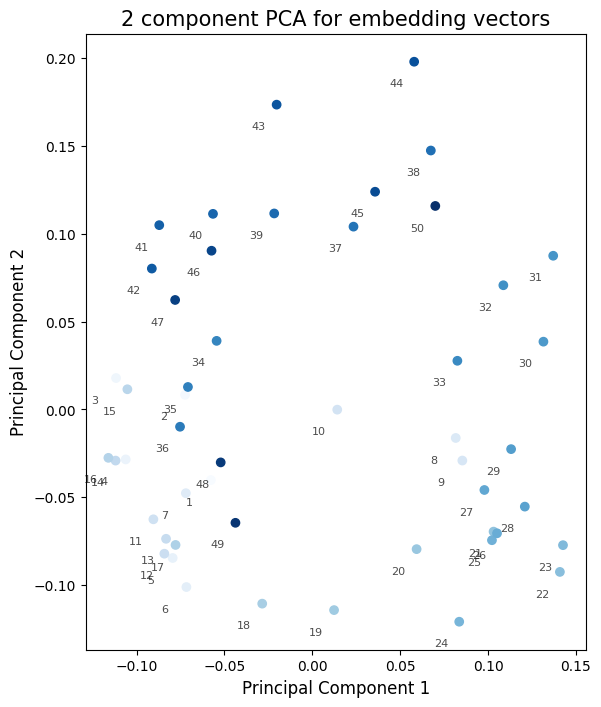

In [13]:
# pca of embedding vectors
pca = PCA(n_components=4)
num_tokens = [str(i) for i in range(1, 51)]
num_token_ids = [token2id[i] for i in num_tokens]
x = model.wte.weight.data.cpu().numpy()[num_token_ids, :]
pca.fit(x)
x_pca = pca.transform(x)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('2 component PCA for embedding vectors', fontsize = 15)
i, j = 1, 2
ax.scatter(x_pca[:, i-1], x_pca[:, j-1], cmap='Blues', c=[p for p in range(x_pca.shape[0])])
ax.set_xlabel(f'Principal Component {i}', fontsize = 12)
ax.set_ylabel(f'Principal Component {j}', fontsize = 12)
xrange, yrange = ax.get_xlim()[1]-ax.get_xlim()[0], ax.get_ylim()[1]-ax.get_ylim()[0]
offset = np.array((min(xrange, yrange), min(xrange, yrange))) / 20
for t in range(x_pca.shape[0]):
    ax.text(*(np.array((x_pca[t, i-1], x_pca[t, j-1]))-offset), num_tokens[t], fontsize=8, color="k", alpha=0.7)
ax.set_aspect(1)
plt.show()

/tmp/ipykernel_974939/3977671324.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=315)


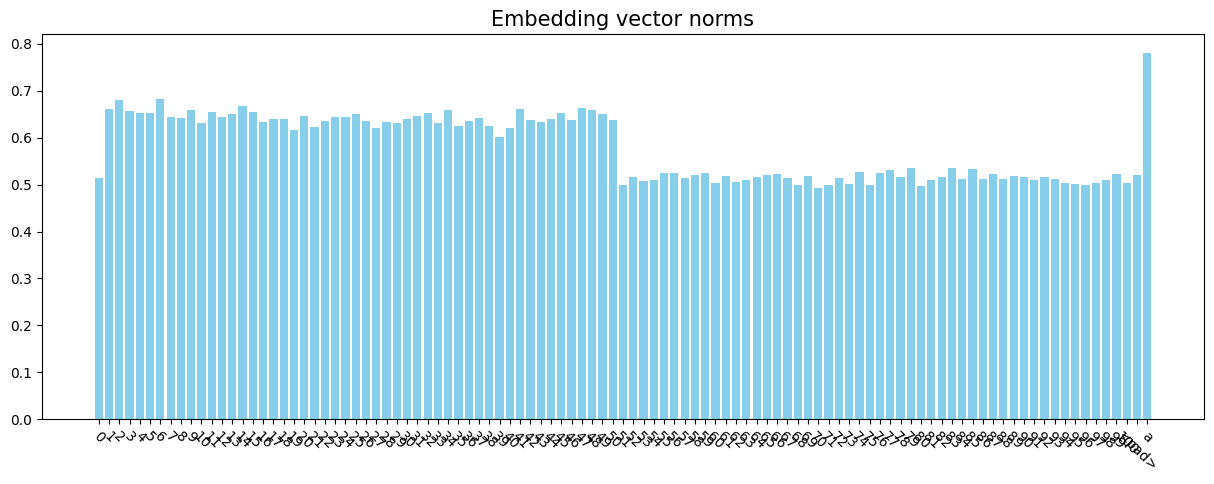

/tmp/ipykernel_974939/3977671324.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=315)


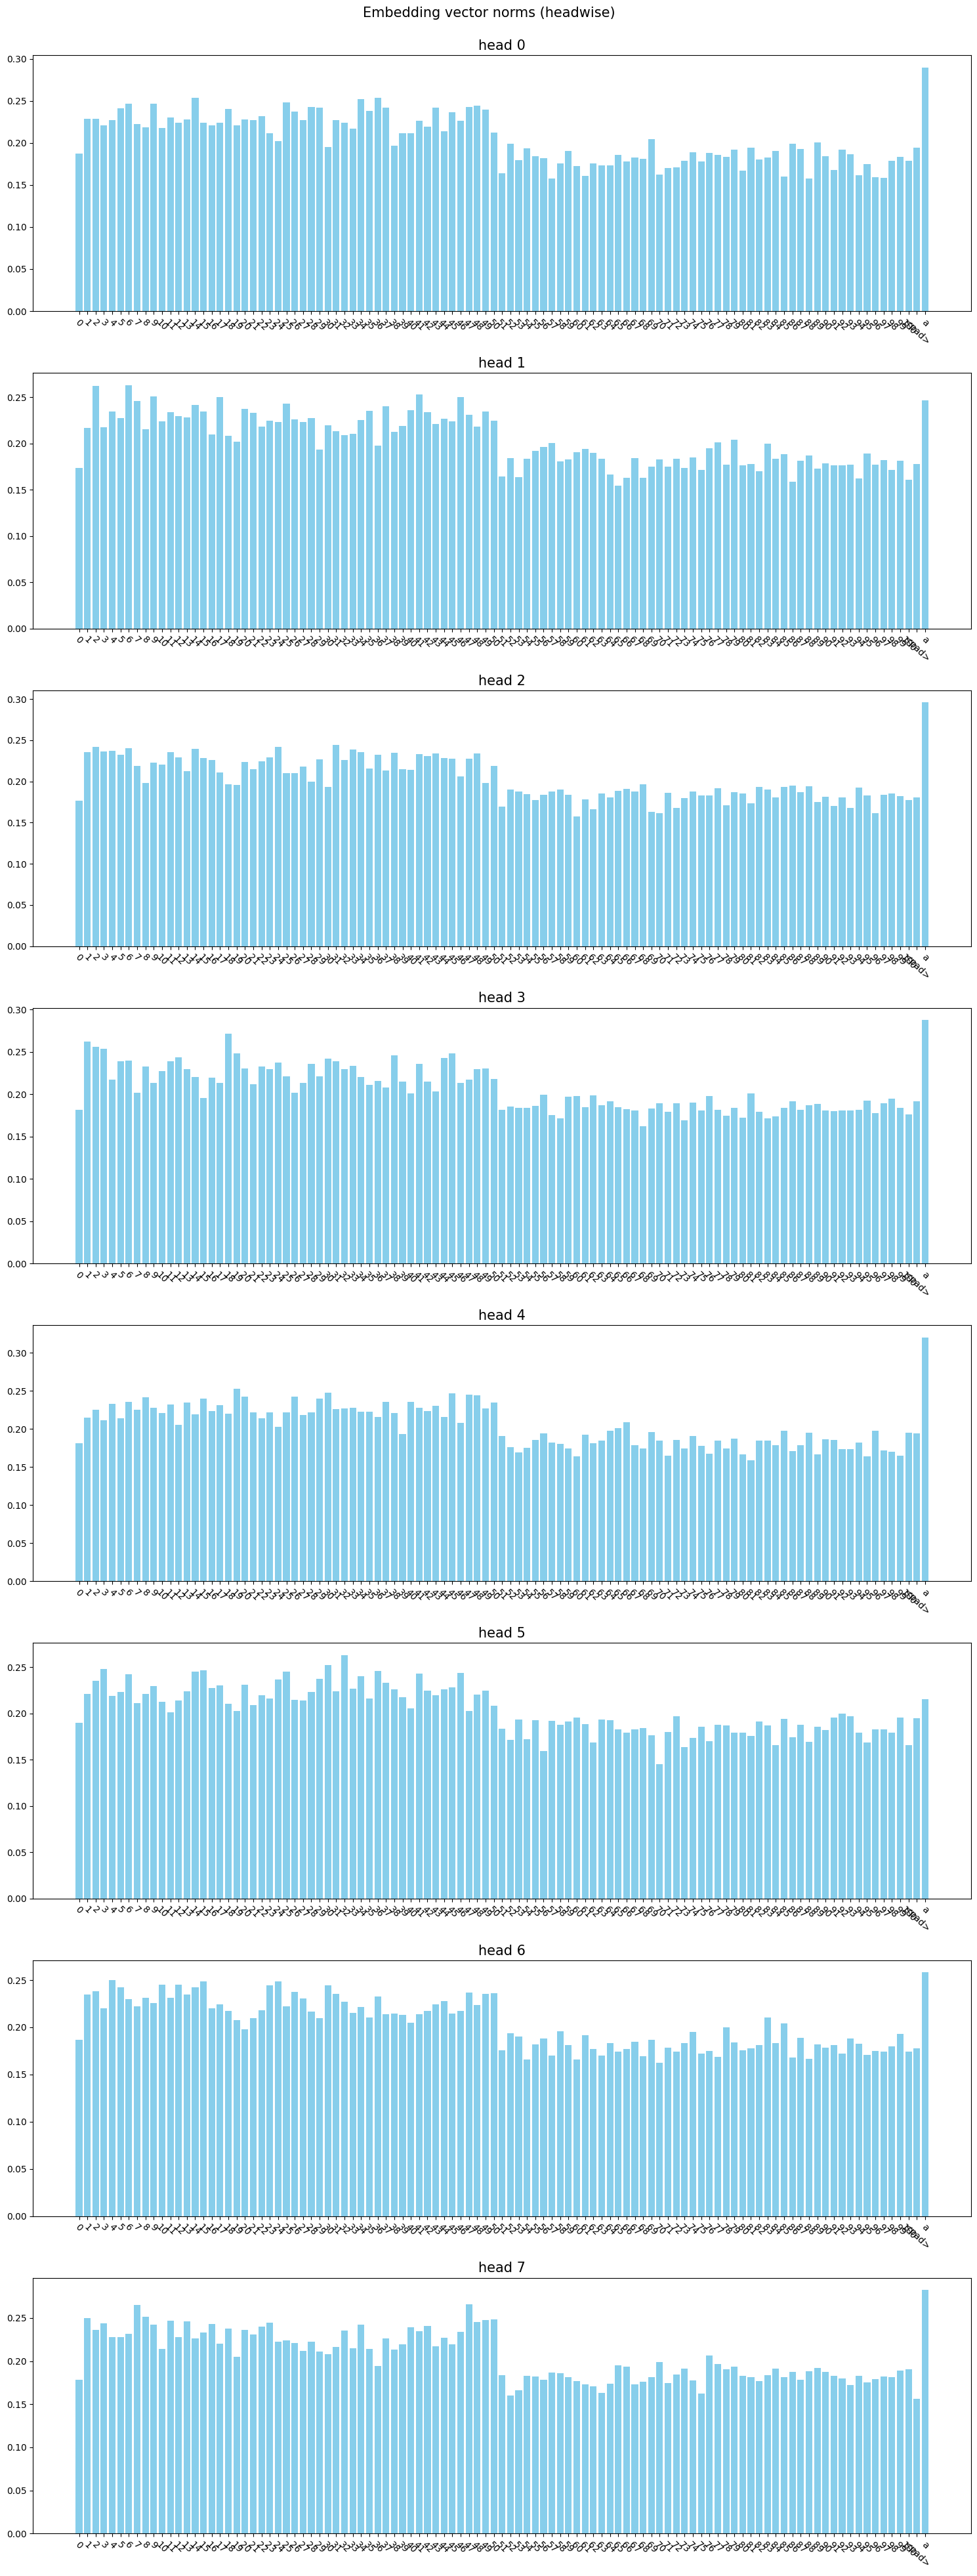

In [35]:
x = model.wte.weight.data.cpu().numpy()
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
ax.bar(model.config.vocab, np.linalg.norm(x, axis=1), color ='skyblue', width = 0.8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=315)
ax.set_title('Embedding vector norms', fontsize = 15)
plt.show()

h = model.config.num_attention_heads
head_dim = model.config.hidden_size // h
fig = plt.figure(figsize=(15, 5*h))
for _h in range(h):
    x = model.wte.weight.data.cpu().numpy()[:, _h*head_dim:(_h+1)*head_dim]
    ax = fig.add_subplot(h, 1, _h+1)
    ax.bar(model.config.vocab, np.linalg.norm(x, axis=1), color ='skyblue', width = 0.8)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=315)
    ax.set_title(f"head {_h}", fontsize = 15)
plt.suptitle('Embedding vector norms (headwise)', fontsize = 15)
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

x.shape =  (50, 128)


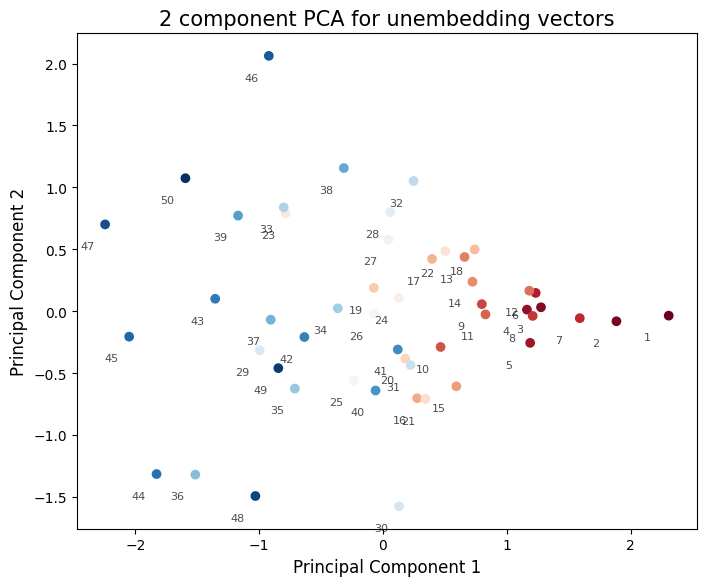

In [12]:
# pca of unembedding vectors
pca = PCA(n_components=4)
num_tokens = [str(i) for i in range(1, 51)]
num_token_ids = [token2id[i] for i in num_tokens]
x = model.lm_head.weight.data.cpu().numpy()[num_token_ids, :]
print("x.shape = ", x.shape)
pca.fit(x)
x_pca = pca.transform(x)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('2 component PCA for unembedding vectors', fontsize = 15)
i, j = 1, 2
ax.scatter(x_pca[:, i-1], x_pca[:, j-1], cmap='RdBu', c=[p for p in range(x_pca.shape[0])])
ax.set_xlabel(f'Principal Component {i}', fontsize = 12)
ax.set_ylabel(f'Principal Component {j}', fontsize = 12)
xrange, yrange = ax.get_xlim()[1]-ax.get_xlim()[0], ax.get_ylim()[1]-ax.get_ylim()[0]
#offset = np.array((xrange, yrange)) / 20
offset = np.array((min(xrange, yrange), min(xrange, yrange))) / 20
for t in range(x_pca.shape[0]):
    ax.text(*(np.array((x_pca[t, i-1], x_pca[t, j-1]))-offset), num_tokens[t], fontsize=8, color="k", alpha=0.7)
ax.set_aspect(1)
plt.show()

### Attention Matrix

In [26]:
input_tokens = ['<bos>', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
input_ids = torch.LongTensor([[token2id[x] for x in input_tokens]]).to(device)

#position_ids_fake = torch.LongTensor([[1]*len(input_tokens)]).to(device)
#position_ids = position_ids_fake
shift_value = random.randint(0, model.config.max_position_embeddings - len(input_tokens))
position_ids = torch.LongTensor([list(range(shift_value, shift_value + len(input_tokens)))]).to(device)
print("position_ids = ", position_ids)
attention_mask = torch.zeros([1, 1, 1, len(input_tokens)]).to(device)

position_ids =  tensor([[33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]], device='cuda:0')


In [38]:
token_embs = model.wte(input_ids)
if model.config.absolute_posemb:
    position_embeds = model.wpe(position_ids)
    input_embs = token_embs + position_embeds
elif model.config.sinusoidal_posemb:
    position_embeds = model.sine(position_ids)
    input_embs = token_embs * math.sqrt(model.embed_dim) + position_embeds
else: input_embs = token_embs

hidden_states = input_embs
block = model.h[0]
query, key, value = block.attn.c_attn(block.ln_1(hidden_states)).split(block.attn.split_size, dim=2)

query = block.attn.split_heads(query)
key = block.attn.split_heads(key)
value = block.attn.split_heads(value)
#block.attn.config.rotary_posemb = False
attn_output_raw, attn_patterns, raw_attn_scores = block.attn._attn(query, key, value, attention_mask, position_ids)

block.attn.config.rotary_posemb =  False


In [39]:
print(raw_attn_scores.shape)


torch.Size([1, 8, 11, 11])


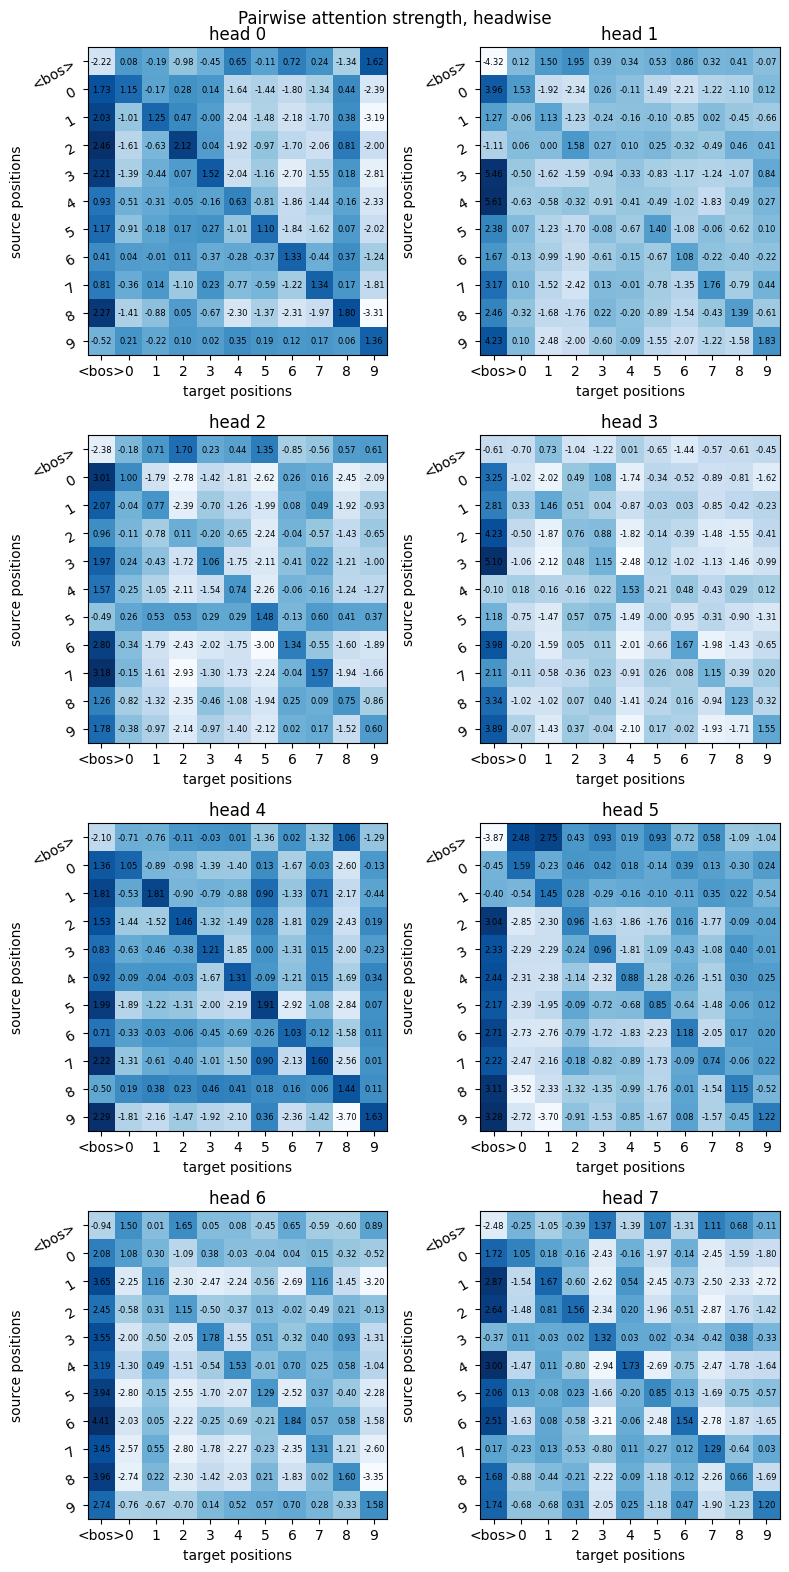

In [40]:
### raw attn scores (for short sequences, so that we can show all tick labels)
### headwise
h = config.num_attention_heads
fig = plt.figure(figsize=(8, 4*math.ceil(h/2)))
for _h in range(h):
    ax = fig.add_subplot(math.ceil(h/2), 2, _h+1)

    x = raw_attn_scores.squeeze()[_h].cpu().detach().numpy()[:torch.count_nonzero(position_ids).item(), :torch.count_nonzero(position_ids).item()]
    #x = np.exp(x)
    #x = (x - x.min(axis=1)[:, None]) / (x.max(axis=1) - x.min(axis=1))[:, None]
    ax.pcolormesh(x, cmap='Blues')

    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            text = ax.text(j + 0.5, i + 0.5, f'{x[i, j]:.2f}', ha='center', va='center', color='k', fontsize=6)
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_ylabel("source positions")
    ax.set_xlabel("target positions")
    ax.set_xticks(np.arange(x.shape[1])+0.5)
    ax.set_xticklabels([model.config.vocab[i.item()] for i in input_ids[0]])
    ax.set_yticks(np.arange(x.shape[0])+0.5)
    ax.set_yticklabels([model.config.vocab[i.item()] for i in input_ids[0]], rotation=30)
    ax.set_title(f"head {_h}")
fig.suptitle(f"Pairwise attention strength, headwise", fontsize=12)
fig.tight_layout()
plt.tight_layout()

# figname_suffix = ""
# os.makedirs(f"{SAVE_VIZ_DIR}/{handle}", exist_ok=True)
# figname_suffix = f"_pids={'-'.join([str(x.item()) for x in position_ids[0]])}"
# fig.savefig(f"{SAVE_VIZ_DIR}/{handle}/raw_attn_scores_headwise{figname_suffix}.png", dpi=256)


In [49]:
### raw attn scores (for short sequences, so that we can show all tick labels)
### headwise
### each cell value is the std over all possible 
#   PID pairs which the source and target tokens can take

#input_tokens = ['<bos>', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
input_tokens = ['<bos>', '7']

h = config.num_attention_heads
max_pid = config.max_position_embeddings
M = np.zeros((max_pid * (max_pid+1) // 2, h, len(input_tokens), len(input_tokens)))

m0 = 0

# -------------------------------------------------------------------------------------------
# This is to check whether the raw_attn_scores from <tok_source, pid = m> to <tok_target, pid=n>  
# in RoPE are identical as long as tok_source, tok_target, m-n remain the same.
#piddist2raw_attn_score = defaultdict(lambda: defaultdict(list))
# -------------------------------------------------------------------------------------------

for pid_target in trange(max_pid):
    position_ids_batch = []
    for pid_source in range(pid_target, max_pid):
        position_ids = torch.LongTensor([[pid_target]*len(input_tokens) + [pid_source]*len(input_tokens)]).to(device)
        #print("position_ids = ", position_ids)
        position_ids_batch.append(position_ids)
    bs = len(position_ids_batch)
    position_ids_batch = torch.cat(position_ids_batch, dim=0)
    attention_mask = torch.zeros([bs, 1, 1, len(input_tokens)*2]).to(device)
    input_ids_batch = torch.LongTensor([[token2id[x] for x in input_tokens*2]]*bs).to(device)
    # print(f"position_ids_batch.shape = {position_ids_batch.shape}")
    # print(f"attention_mask.shape = {attention_mask.shape}")
    # print(f"input_ids.shape = {input_ids.shape}")
    
    token_embs = model.wte(input_ids_batch)

    if model.config.absolute_posemb:
        position_embeds = model.wpe(position_ids_batch)
        input_embs = token_embs + position_embeds
    elif model.config.sinusoidal_posemb:
        position_embeds = model.sine(position_ids_batch)
        input_embs = token_embs * math.sqrt(model.embed_dim) + position_embeds
    
    else: input_embs = token_embs

    hidden_states = input_embs
    block = model.h[0]
    query, key, value = block.attn.c_attn(block.ln_1(hidden_states)).split(block.attn.split_size, dim=2)

    query = block.attn.split_heads(query)
    key = block.attn.split_heads(key)
    value = block.attn.split_heads(value)

    attn_output_raw, attn_patterns, raw_attn_scores = block.attn._attn(query, key, value, attention_mask, position_ids_batch)
    # attn_output_raw shape: (bs, h, len(input_tokens)*2, len(input_tokens)*2)
    M[m0:m0+bs] = raw_attn_scores[:, :, len(input_tokens):, :len(input_tokens)].cpu().detach().numpy()
    m0 += bs

    # -------------------------------------------------------------------------------------------
    # for _bs, pid_source in enumerate(list(range(pid_target, max_pid))):
    #     for _h, x in enumerate(raw_attn_scores[_bs, :, -1, 0].squeeze().cpu().detach().numpy()):
    #         piddist2raw_attn_score[_h][pid_source-pid_target].append(x)
    # -------------------------------------------------------------------------------------------
    
    #break

100%|██████████| 128/128 [00:00<00:00, 188.64it/s]


In [78]:
M1 = rearrange(M, 'm h s t -> s t h m')

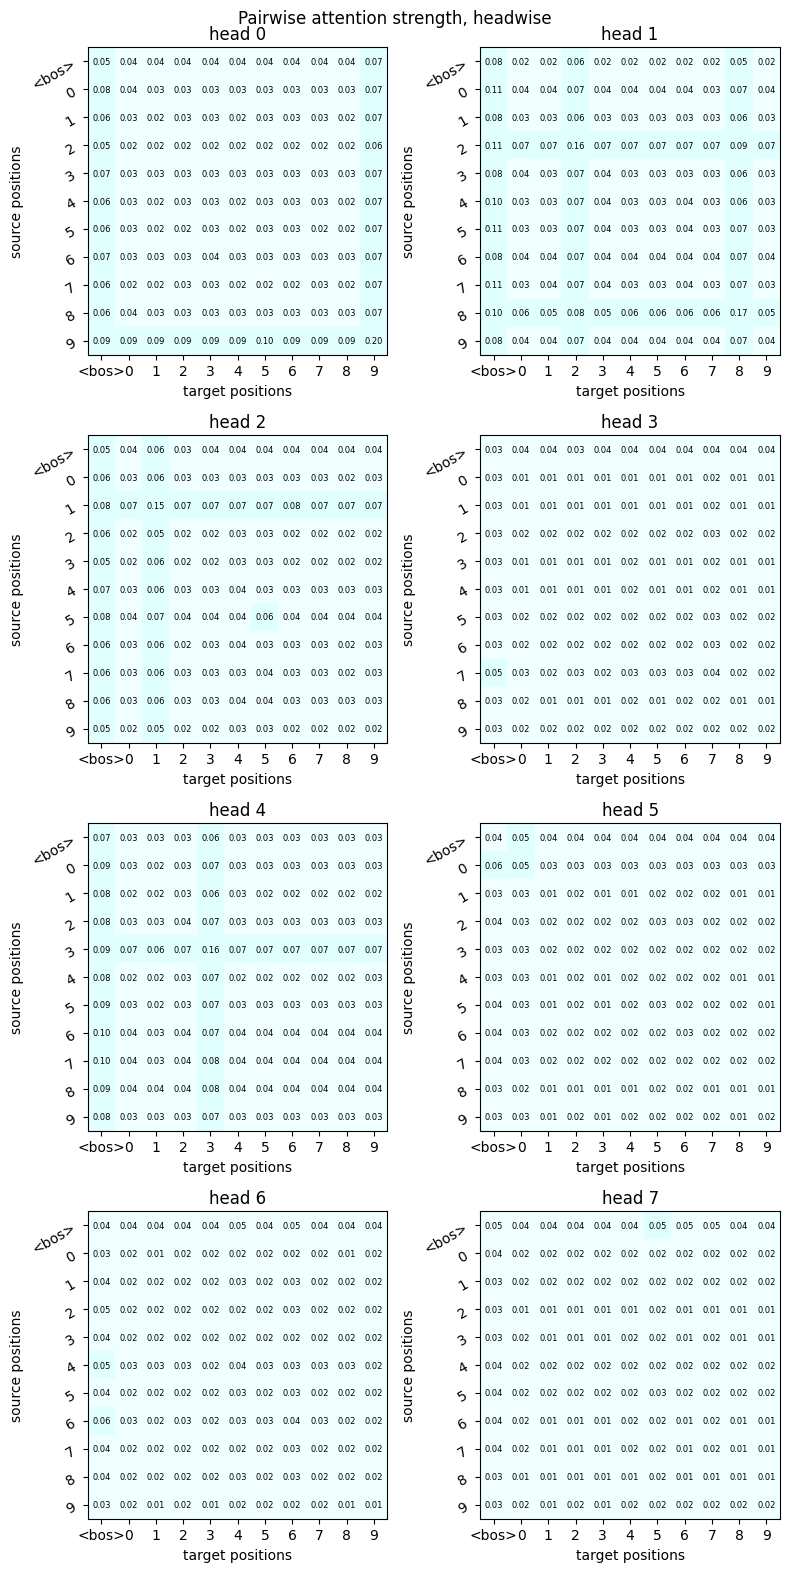

In [79]:
groups = [0, 0.05, 0.2, 0.5, 1, 2, 5]
#colors = ['ivory', 'lightyellow', 'lemonchiffon', 'khaki', 'goldenrod', 'darkgoldenrod', 'saddlebrown']
colors = ['azure', 'lightcyan', 'lightskyblue', 'dodgerblue', 'royalblue', 'mediumblue']
cmap = ListedColormap(colors)
norm = BoundaryNorm(groups, cmap.N)

fig = plt.figure(figsize=(8, 4*math.ceil(h/2)))
for _h in range(h):
    ax = fig.add_subplot(math.ceil(h/2), 2, _h+1)
    x = M1.std(axis=-1)[:, :, _h]
    ax.pcolormesh(x, cmap=cmap, norm=norm)
    #ax.pcolormesh(x, cmap='Blues')

    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            text = ax.text(j + 0.5, i + 0.5, f'{x[i, j]:.2f}',
                        ha='center', va='center', color='k', fontsize=6)
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_ylabel("source positions")
    ax.set_xlabel("target positions")
    ax.set_xticks(np.arange(x.shape[1])+0.5)
    ax.set_xticklabels(input_tokens)
    ax.set_yticks(np.arange(x.shape[0])+0.5)
    ax.set_yticklabels(input_tokens, rotation=30)
    ax.set_title(f"head {_h}")
fig.suptitle(f"Pairwise attention strength, headwise", fontsize=12)
fig.tight_layout()
plt.tight_layout()

os.makedirs(f"{SAVE_VIZ_DIR}/{handle}", exist_ok=True)
fig.savefig(f"{SAVE_VIZ_DIR}/{handle}/raw_attn_scores_headwise_variation_wrt_pids.png", dpi=256)

In [8]:
### raw attn scores (for short sequences, so that we can show all tick labels)
### headwise
### attn from 'a' to a number_token 
#   x-axis: PID difference between 'a' and the number_token
#   y-axis: number_token

num_tokens = sorted([x for x in model.config.vocab if x.isdigit()], key = lambda x: int(x))

h = config.num_attention_heads
max_pid = config.max_position_embeddings
M = np.zeros((len(num_tokens), h, max_pid-1))

pid_target = 0
for pid_source in range(1, max_pid):
    position_ids_batch = torch.LongTensor([[pid_target, pid_source]]*len(num_tokens)).to(device)
    attention_mask = torch.zeros([len(num_tokens), 1, 1, 2]).to(device)
    input_ids_batch = torch.stack([torch.LongTensor([token2id['a']]*len(num_tokens)), torch.LongTensor([token2id[x] for x in num_tokens])], dim=1).to(device)
    # print(f"position_ids_batch.shape = {position_ids_batch.shape}")
    # print(f"attention_mask.shape = {attention_mask.shape}")
    # print(f"input_ids_batch.shape = {input_ids_batch.shape}")
    
    token_embs = model.wte(input_ids_batch)

    if model.config.absolute_posemb:
        position_embeds = model.wpe(position_ids_batch)
        input_embs = token_embs + position_embeds
    elif model.config.sinusoidal_posemb:
        position_embeds = model.sine(position_ids_batch)
        input_embs = token_embs * math.sqrt(model.embed_dim) + position_embeds
    
    else: input_embs = token_embs

    hidden_states = input_embs
    block = model.h[0]
    query, key, value = block.attn.c_attn(block.ln_1(hidden_states)).split(block.attn.split_size, dim=2)

    query = block.attn.split_heads(query)
    key = block.attn.split_heads(key)
    value = block.attn.split_heads(value)

    attn_output_raw, attn_patterns, raw_attn_scores = block.attn._attn(query, key, value, attention_mask, position_ids_batch)
    M[:, :, pid_source-1] = raw_attn_scores[:, :, 1, 0].cpu().detach().numpy()

    #break

  0%|          | 0/101 [00:00<?, ?it/s]

100%|██████████| 101/101 [00:02<00:00, 39.18it/s]


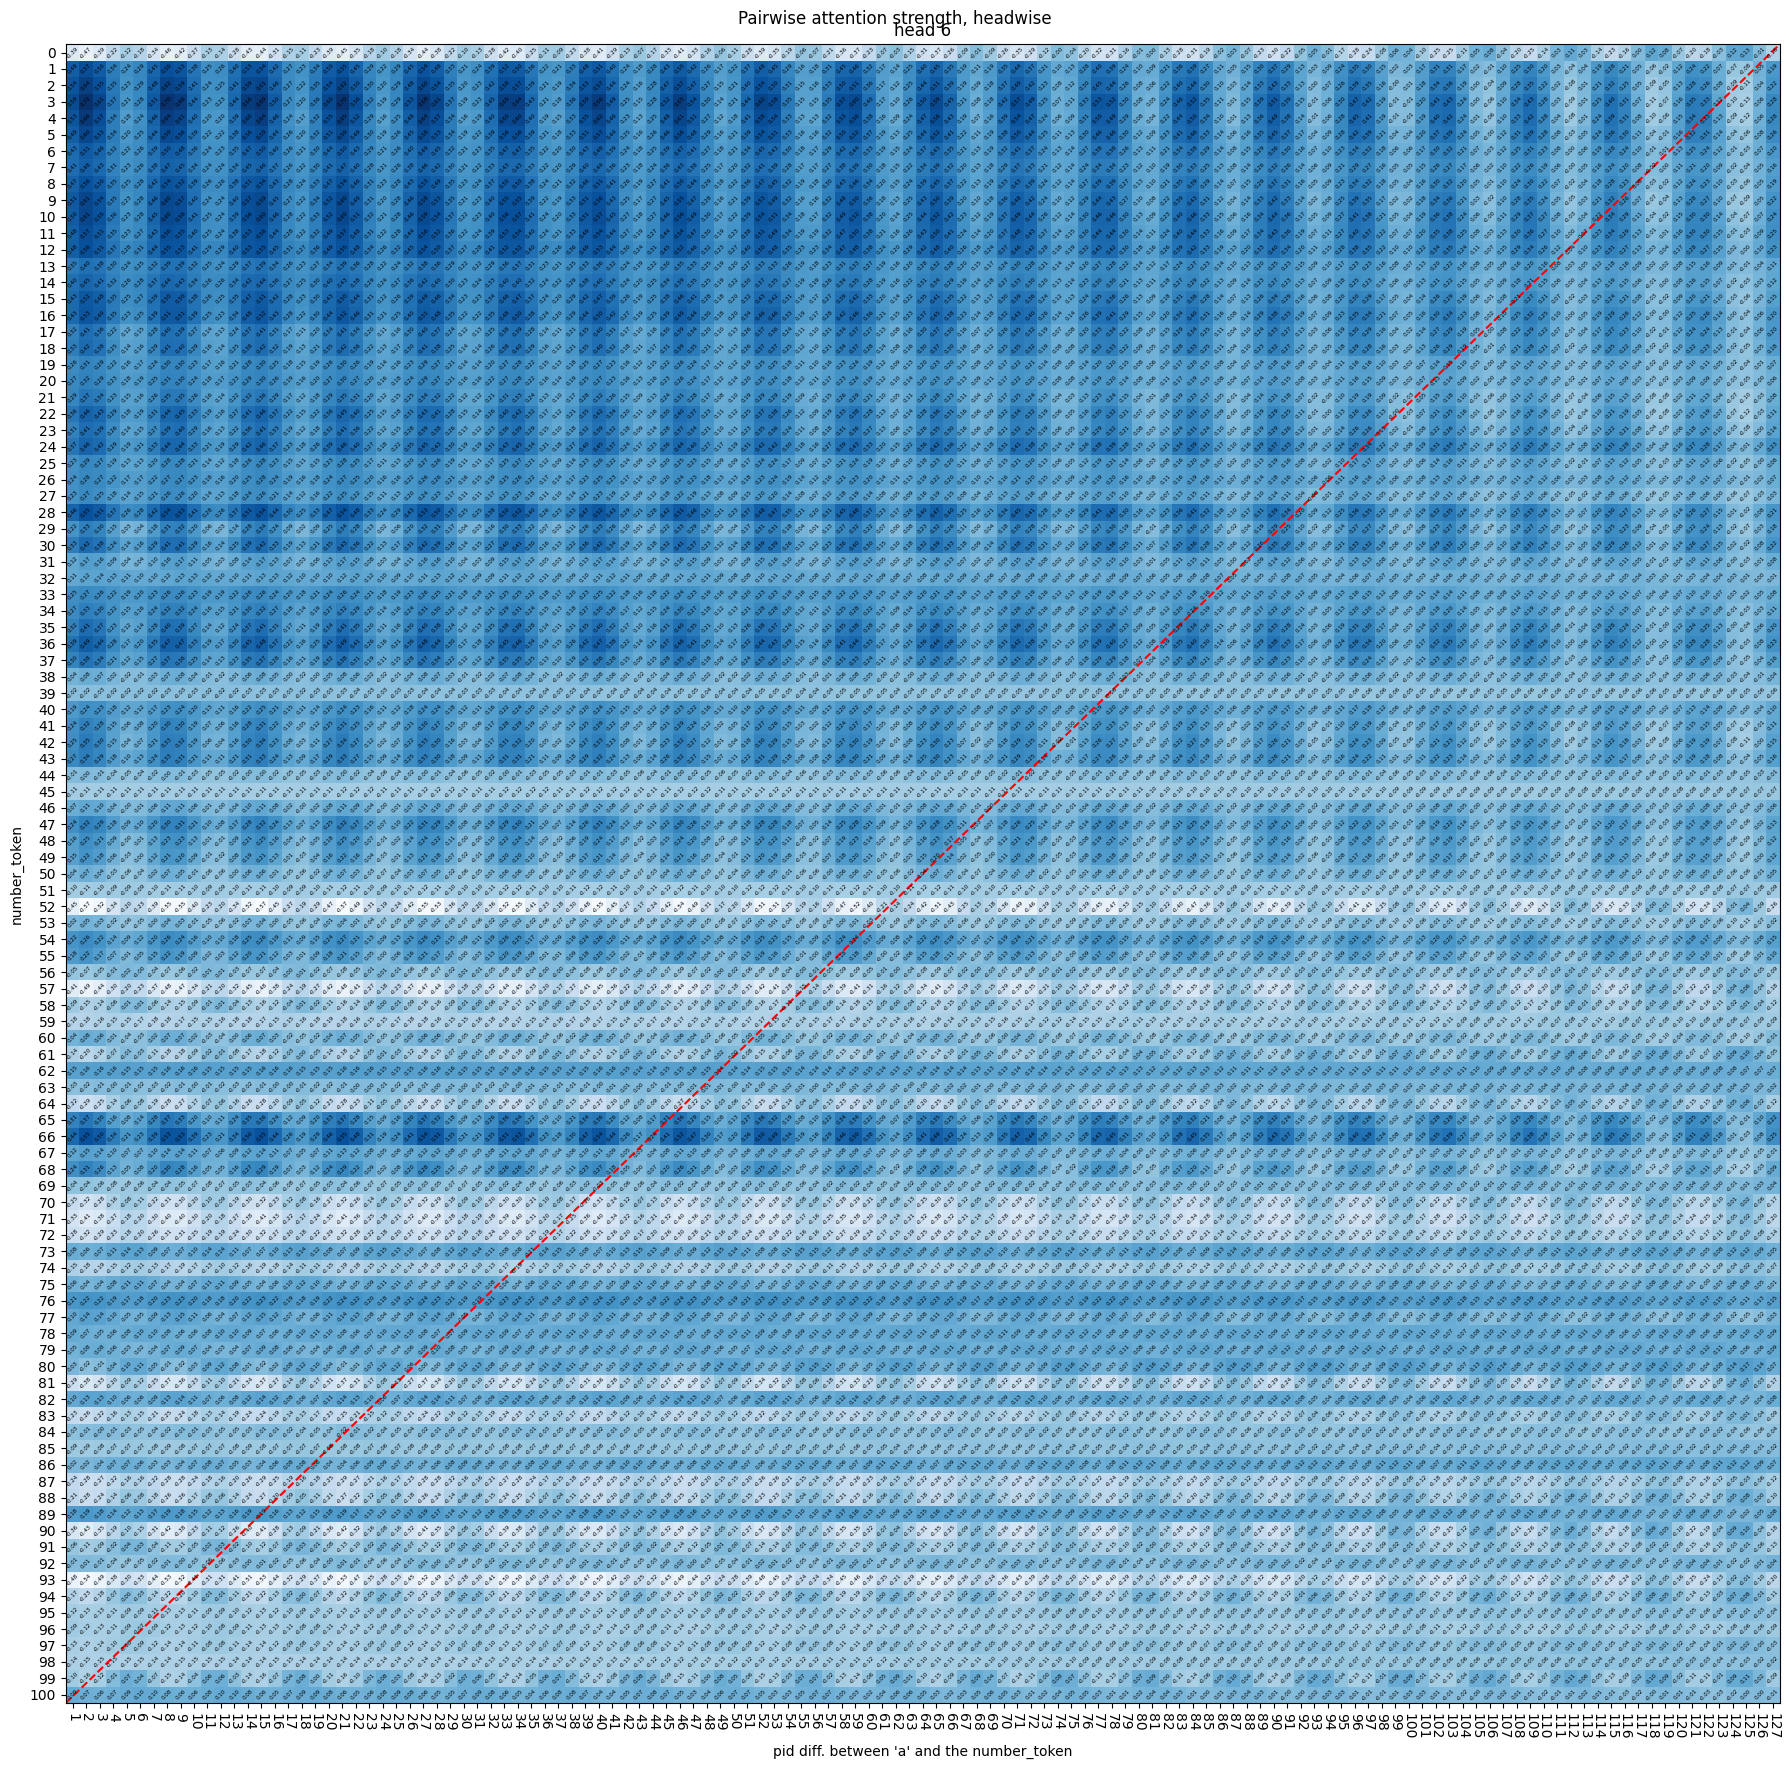

In [19]:
fig = plt.figure(figsize=(18, 18))
_h = 6

ax = fig.add_subplot(111)
x = M[:, _h, :]
#x = (x - x.min(axis=1)[:, None]) / (x.max(axis=1) - x.min(axis=1))[:, None]
ax.pcolormesh(x, cmap='Blues')

for i in trange(x.shape[0]):
    for j in range(x.shape[1]):
        text = ax.text(j + 0.5, i + 0.5, f'{x[i, j]:.2f}', rotation=45,
                    ha='center', va='center', color='k', fontsize=4)
ax.plot([0, x.shape[1]], [x.shape[0], 0], color='red', linestyle='--')

ax.set_ylim(ax.get_ylim()[::-1])
ax.set_ylabel("number_token")
ax.set_xlabel("pid diff. between 'a' and the number_token")
ax.set_xticks(np.arange(x.shape[1])+0.5)
ax.set_xticklabels(list(range(1, max_pid)), rotation=270)
ax.set_yticks(np.arange(x.shape[0])+0.5)
ax.set_yticklabels(num_tokens)
ax.set_title(f"head {_h}")

fig.suptitle(f"Pairwise attention strength, headwise", fontsize=12)
fig.tight_layout()
plt.tight_layout()

os.makedirs(f"{SAVE_VIZ_DIR}/{handle}", exist_ok=True)
fig.savefig(f"{SAVE_VIZ_DIR}/{handle}/raw_attn_scores_a-to-a_head{_h}.png", dpi=256)

In [14]:
### raw attn scores (for short sequences, so that we can show all tick labels)
### headwise
### attn from 'a' to 'a' 
#   x-axis: PID difference

num_tokens = sorted([x for x in model.config.vocab if x.isdigit()], key = lambda x: int(x))

h = config.num_attention_heads
max_pid = config.max_position_embeddings

pid_target = 0
position_ids_batch = torch.LongTensor([[pid_target, pid_source] for pid_source in range(1, max_pid)]).to(device)
attention_mask = torch.zeros([max_pid-1, 1, 1, 2]).to(device)
input_ids_batch = torch.LongTensor([[token2id['a']]*2]*(max_pid-1)).to(device)
print(f"position_ids_batch.shape = {position_ids_batch.shape}")
print(f"attention_mask.shape = {attention_mask.shape}")
print(f"input_ids_batch.shape = {input_ids_batch.shape}")

token_embs = model.wte(input_ids_batch)

if model.config.absolute_posemb:
    position_embeds = model.wpe(position_ids_batch)
    input_embs = token_embs + position_embeds
elif model.config.sinusoidal_posemb:
    position_embeds = model.sine(position_ids_batch)
    input_embs = token_embs * math.sqrt(model.embed_dim) + position_embeds

else: input_embs = token_embs

hidden_states = input_embs
block = model.h[0]
query, key, value = block.attn.c_attn(block.ln_1(hidden_states)).split(block.attn.split_size, dim=2)

query = block.attn.split_heads(query)
key = block.attn.split_heads(key)
value = block.attn.split_heads(value)

attn_output_raw, attn_patterns, raw_attn_scores = block.attn._attn(query, key, value, attention_mask, position_ids_batch)
print(raw_attn_scores.shape)


position_ids_batch.shape = torch.Size([127, 2])
attention_mask.shape = torch.Size([127, 1, 1, 2])
input_ids_batch.shape = torch.Size([127, 2])
torch.Size([127, 8, 2, 2])


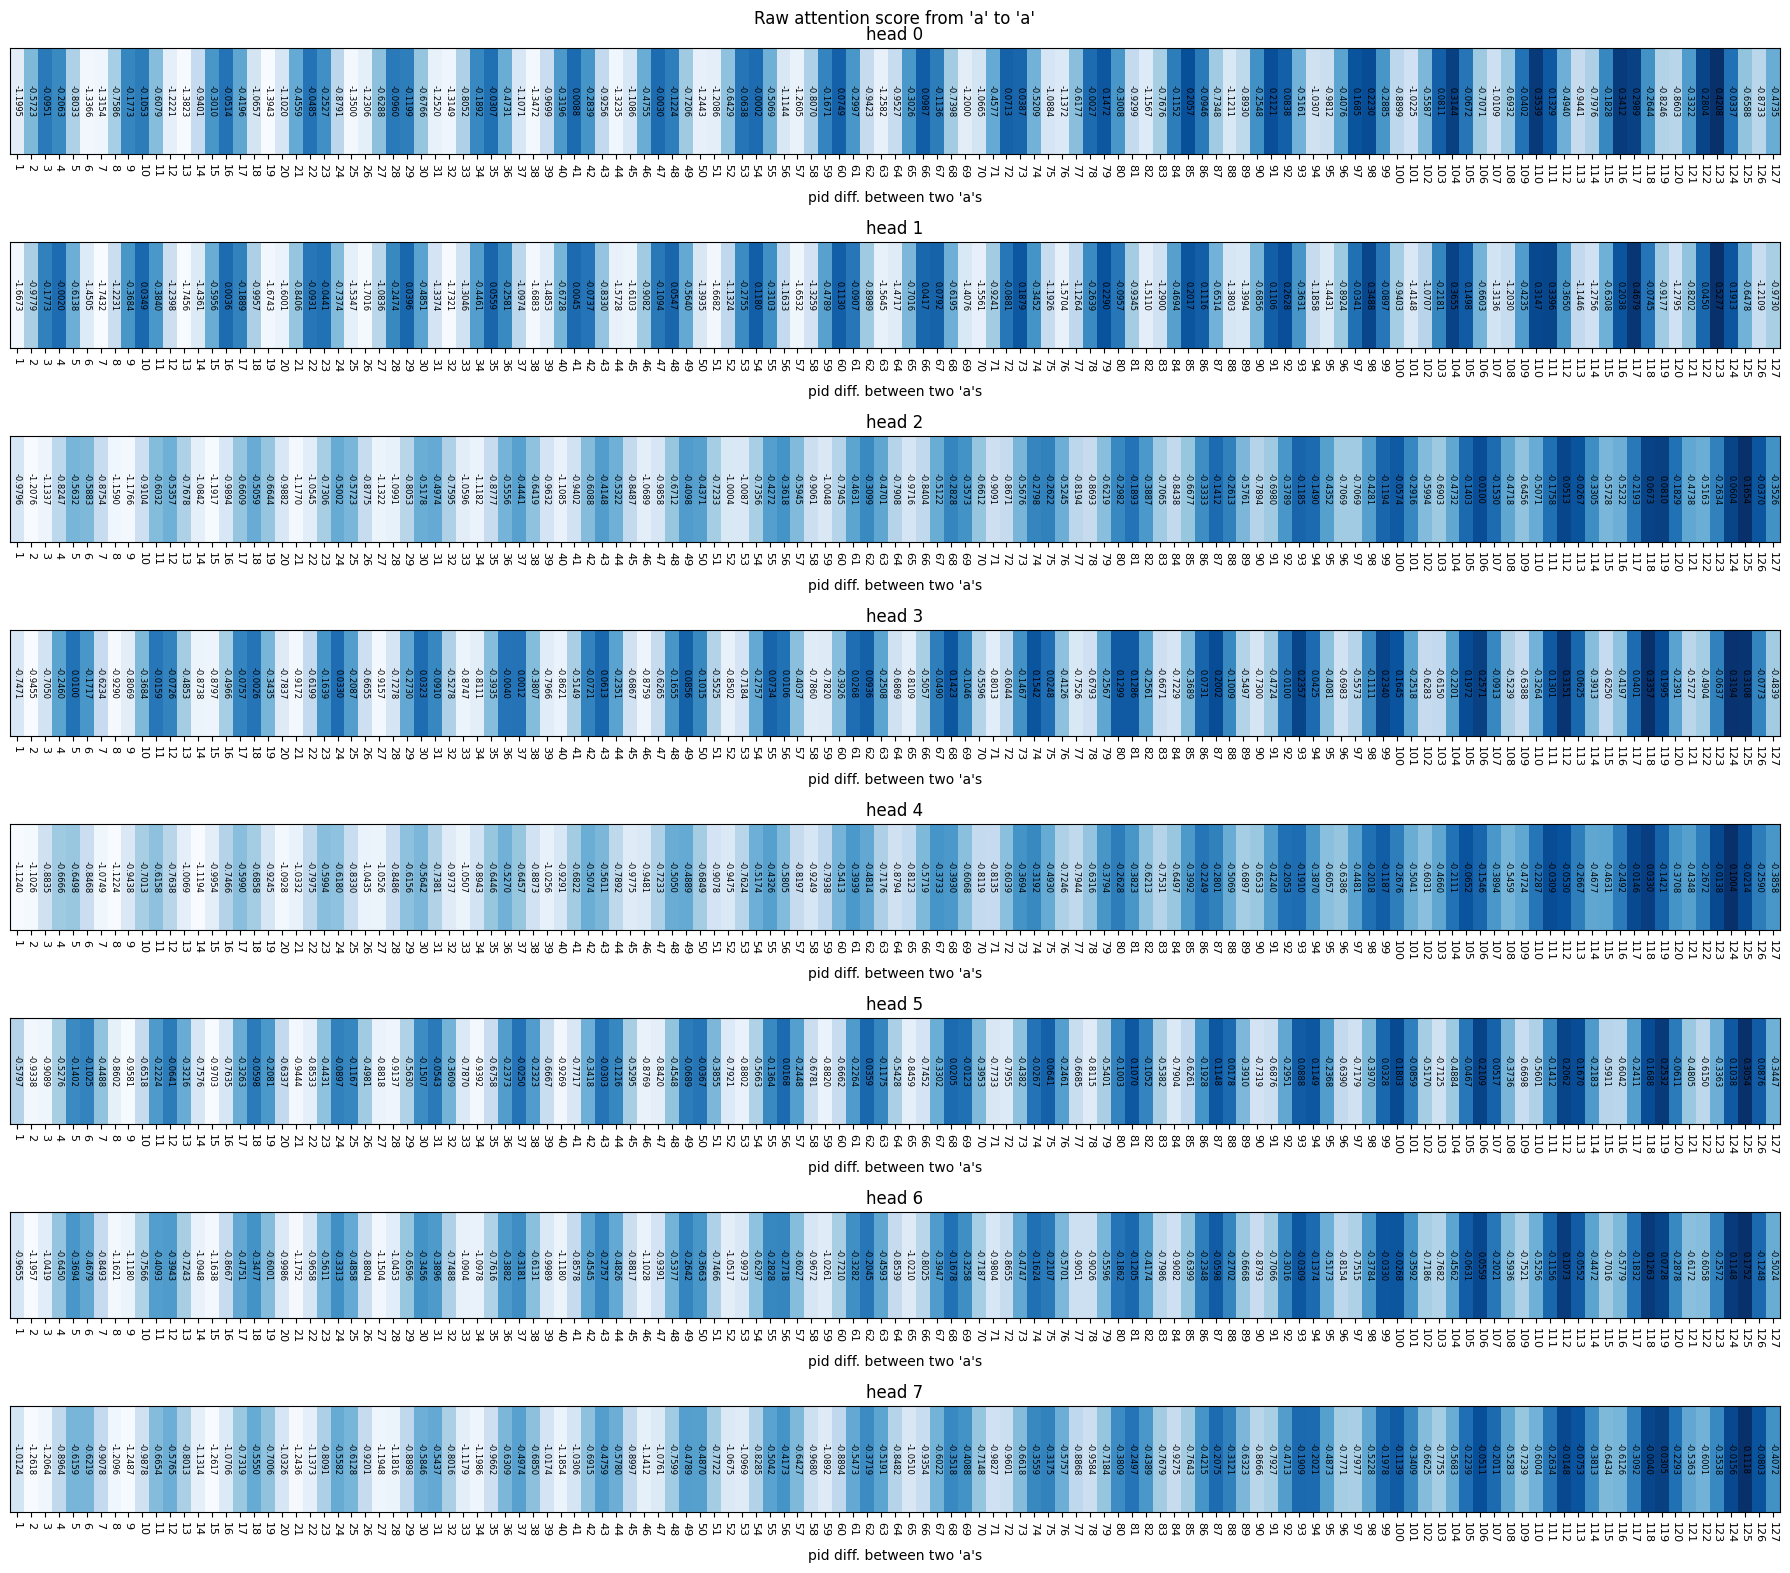

In [17]:
fig = plt.figure(figsize=(18, 2*h))

for _h in range(h):
    ax = fig.add_subplot(h, 1, _h+1)
    x = raw_attn_scores[:, _h, 1, 0].unsqueeze(0).cpu().detach().numpy()
    ax.pcolormesh(x, cmap='Blues')

    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            text = ax.text(j + 0.5, i + 0.5, f'{x[i, j]:.4f}', rotation=270,
                        ha='center', va='center', color='k', fontsize=6)
    ax.set_xlabel("pid diff. between two 'a's")
    ax.set_xticks(np.arange(x.shape[1])+0.5)
    ax.set_xticklabels(list(range(1, max_pid)), rotation=270, fontsize=8)
    ax.set_yticks([])
    ax.set_title(f"head {_h}")

fig.suptitle(f"Raw attention score from 'a' to 'a'", fontsize=12)
fig.tight_layout()
plt.tight_layout()

os.makedirs(f"{SAVE_VIZ_DIR}/{handle}", exist_ok=True)
fig.savefig(f"{SAVE_VIZ_DIR}/{handle}/raw_attn_scores_a-to-a.png", dpi=256)

### Draft